### News Classification Analysis: Simple Neural Network vs. Bi-directional RNN, Bi_Directional LSTM

Here we use Simple Neural Network, Bi-directional RNN and Bi_Directional LSTM to classify given news dataset into 4 classes:

○ World (0)
○ Sports (1)
○ Business (2)
○ Sci/Tech (3)

We cleaned the dataset first:

-> Converted the whole dataset to lower case.

-> Removed stop words.

-> Removed punctuation marks.

-> Replaced numbers and words containing numbers as a sunstring with "NUM" tokens.

We have used here word2vec model to convert our news sentences to embeddings instead of the nn.Embedding Layer to learn the same.

In Simple Neural Network, we have used word2vec word embeddings of the words to feed into the network. Using this network we could achieve 82.34 % accuracy on the test set. We trained the model for 25 epochs to learn the pattern to the best using AdamW optimizer using a LR of 0.003

In Bi-RNN we have used nn.Embedding layer but initialized it with the word2vec embeddings and freezed the embedding layer so that it dont receives the gradient updates and learn new embeddings. Here we could achieve an accuracy of 83.25 % on the test set. We trained the model for 20 epochs to learn the pattern to the best using AdamW optimizer using a LR of 0.0001 

In Bi-LSTM we have used nn.Embedding layer but initialized it with the word2vec embeddings and freezed the embedding layer so that it dont receives the gradient updates and learn new embeddings. Here we could achieve an accuracy of 82.23 % on the test set. We trained the model for 20 epochs to learn the pattern to the best using AdamW optimizer using a LR of 0.00005 


In [1]:
import nltk
import re
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

##### Load the train data

In [2]:
train_set = pd.read_csv('./NLP3/train.csv')

In [3]:
train_set.head()

,index,text,label
0,0,Zimbabwe annual inflation drops to 209 percent...,0
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0
3,3,Security No. 1 for Afghan head President Hamid...,0
4,4,Palestinians say they hope Bush accepts dealin...,0


In [4]:
print(f'Train set contains total {len(train_set)} rows with {train_set.label.unique()} unique classes(labels)')

Train set contains total 2000 rows with [0 1 2 3] unique classes(labels)


In [5]:
y_train_raw = train_set['label']

In [6]:
# y_train_raw

### Pre-Processing Datasets

In [7]:
def remove_symbols(text):
    pattern = r'[^\w\s]'  
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [8]:
def remove_stopwords(text):
    
    stopwords_set = set(stopwords.words('english'))
    text = text.split()
    stopwords_removed_text = [word for word in text if word.lower() not in stopwords_set]
    
    return ' '.join(stopwords_removed_text)

In [9]:
train_set['text'] = train_set['text'].apply(lambda x: x.lower()) 
train_set['text'] = train_set['text'].apply(remove_symbols) 
train_set['text'] = train_set['text'].apply(remove_stopwords) 
train_set['text'] = train_set['text'].apply(lambda x: x.replace('\\', ' ')) 
train_set['text'] = train_set['text'].replace(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', 'NUM', regex=True)

In [10]:
train_set.head(5)

,index,text,label
0,0,zimbabwe annual inflation drops NUM percent re...,0
1,1,NUM dead haiti NUM mass grave haiti holds NUM ...,0
2,2,seven die japan NUM pact NUM japanese police f...,0
3,3,security NUM afghan head president hamid karza...,0
4,4,palestinians say hope bush accepts dealing ara...,0


##### Load the Test Data

In [11]:
test_set = pd.read_csv('./NLP3/test.csv')

In [12]:
print(f'Test set contains total {len(test_set)} rows with {test_set.label.unique()} unique classes(labels)')

Test set contains total 500 rows with [0 1 2 3] unique classes(labels)


In [13]:
y_test_raw = test_set['label']

In [14]:
# y_test_raw

In [15]:
test_set['text'] = test_set['text'].apply(lambda x: x.lower()) 
test_set['text'] = test_set['text'].apply(remove_symbols) 
test_set['text'] = test_set['text'].apply(remove_stopwords) 
test_set['text'] = test_set['text'].apply(lambda x: x.replace('\\', ' ')) 
test_set['text'] = test_set['text'].replace(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', 'NUM', regex=True)

In [16]:
test_set.head()

,index,text,label
0,0,detainees seen minimal threat washington alleg...,0
1,1,japans army works plan cope north korean terro...,0
2,2,un council arrives nairobi un security council...,0
3,3,apec ministers urge new effort trade talks pac...,0
4,4,least five dead russia mine blast reuters reut...,0


### Vocabulary Creation

In [17]:
def tokenize_sentence(sentence):
    return word_tokenize(sentence)

In [18]:
sentences = train_set['text'].tolist() + test_set['text'].tolist()
tokenized_sentences = [tokenize_sentence(sentence) for sentence in sentences]

In [19]:
len(sentences), len(tokenized_sentences)

(2500, 2500)

In [20]:
# Build vocabulary

vocabulary = set()
for tokens in tokenized_sentences:
    vocabulary.update(tokens)

##### Word2Vec Initialization and Training

In [21]:
import gensim
from gensim.models import Word2Vec

In [22]:
word2vec_model = Word2Vec(tokenized_sentences, vector_size = 100, window = 5, min_count = 1, workers = 4)

In [23]:
word2vec_model.train(tokenized_sentences, total_examples = len(tokenized_sentences), epochs = 50)

(3076388, 3252800)

In [24]:
# find the max length of the sentences for padding

max_length = max(len(seq) for seq in tokenized_sentences)
max_length

97

In [25]:
padded_sequences = np.array([seq + ['<PAD>'] * (max_length - len(seq)) for seq in tokenized_sentences])

In [26]:
# padded_sequence is collection of all the sentences padded with <PAD> token to make length equal to the max_length(97) 
# of all the sentences.

padded_sequences

array([['zimbabwe', 'annual', 'inflation', ..., '<PAD>', '<PAD>',
        '<PAD>'],
       ['NUM', 'dead', 'haiti', ..., '<PAD>', '<PAD>', '<PAD>'],
       ['seven', 'die', 'japan', ..., '<PAD>', '<PAD>', '<PAD>'],
       ...,
       ['cheese', 'sandwich', 'back', ..., '<PAD>', '<PAD>', '<PAD>'],
       ['make', 'hotels', 'like', ..., '<PAD>', '<PAD>', '<PAD>'],
       ['cisco', 'fujitsu', 'team', ..., '<PAD>', '<PAD>', '<PAD>']],
      dtype='<U111')

In [27]:
# Convert words to numeric embeddings

numeric_embeddings = []
for seq in padded_sequences:
    seq_embeddings = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in seq]
    numeric_embeddings.append(seq_embeddings)

In [28]:
# each element in the numeric embedding is the 97 number of 100 dimension vector for each of the 97 words.

print(len(numeric_embeddings))
print(len(numeric_embeddings[0]))

2500
97


In [29]:
avg_embeddings = np.mean(numeric_embeddings, axis=1)

In [30]:
print(len(avg_embeddings))
print(len(avg_embeddings[0]))

2500
100


#### Separating Into Train and Test Set

In [31]:
X_train = avg_embeddings[:2000]
len(X_train)

2000

In [32]:
X_test = avg_embeddings[2000:]
len(X_test)

500

In [33]:
# Convert to Train set to PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_raw, dtype = torch.long)

In [34]:
# Each sentence is represented by a 97*100 tensor, 
# In each sentence we have 97 words, each word represeneted by 100 numbers.
# And total we have 2000 sentences.

# When we have calculated avg embeddings all the 97 vectors of length 100 for a sentence have been compressed into a 
# single vector of len 100.

X_train_tensor.shape

torch.Size([2000, 100])

Now we have x_train, y_train and x_val, y_val

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.15, random_state=42)

In [36]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

torch.Size([1700, 100])
torch.Size([1700])
torch.Size([300, 100])
torch.Size([300])


In [37]:
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_raw, dtype = torch.long)

In [38]:
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([500, 100])
torch.Size([500])


In [39]:
# Dataset and Dataloader Creation

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [40]:
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [41]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

#### Define the Architecture

In [42]:
class TextClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
                
        self.fc1 = nn.Linear( in_features = input_dim, out_features = 256 )
        self.reluActivation1 = nn.ReLU()
        # self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear( in_features = 256, out_features = 128 )
        self.reluActivation2 = nn.ReLU()
        # self.dropout1 = nn.Dropout(0.5)

        self.fc3 = nn.Linear( in_features = 128, out_features = hidden_dim )
        self.reluActivation3 = nn.ReLU()
        # self.dropout2 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear( in_features = hidden_dim, out_features = output_dim )
        self.softmax = nn.Softmax( dim = 1 )
        
    def forward(self, x):
                
        x = self.fc1(x)
        x = self.reluActivation1(x)
        # x = self.dropout1(x)

        x = self.fc2(x)
        x = self.reluActivation2(x)
        # x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.reluActivation3(x)
        # x = self.dropout2(x)

        x = self.fc4(x)
        x = self.softmax(x)
        
        return x
        

In [43]:
# Hyperparameter Declaration

# word2vec_model.vector_size = 100

input_dim = word2vec_model.vector_size
hidden_dim = 64
output_dim = 4

In [44]:
def accuracy_fn(y_true, y_pred):
    
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = ( correct/len(y_pred) ) * 100
    
    return accuracy

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [46]:
# Instantiate the model

textClassifierModel = TextClassifier(input_dim, hidden_dim, output_dim).to(device)
textClassifierModel

TextClassifier(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (reluActivation1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (reluActivation2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (reluActivation3): ReLU()
  (fc4): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [47]:
# Define loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(textClassifierModel.parameters(), lr=0.003)

In [48]:
num_classes = 4
num_epochs = 25
performance_metrics = []
best_val_accuracy = 0

for epoch in tqdm(range(num_epochs)):
    textClassifierModel.train()
    train_loss = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        X, y = X.to(device), y.to(device)
        
        y_pred = textClassifierModel(X)
                
        # calculate batch accumulative loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    with torch.inference_mode():
        
        textClassifierModel.eval()
        val_loss, val_accuracy = 0,0
        
        for X_val, y_val in val_loader:
            
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            y_val_pred = textClassifierModel(X_val)
            
            loss = loss_fn(y_val_pred, y_val)
            val_loss += loss
            val_accuracy += accuracy_fn(y_val, y_val_pred.argmax(dim=1))
        
        # Calculate avg. loss & accuracy
        
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        val_accuracy = val_accuracy/len(val_loader)
        
        print(f"Epoch:{epoch+1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")
        performance_metrics.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            torch.save(textClassifierModel.state_dict(), './best_text_classifier_model.pth')
            print('Model State Dict Saved\n')
            best_val_accuracy = val_accuracy

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:1 | Train loss: 1.1064 | Val loss: 0.9332 | Val accuracy: 81.0417
Model State Dict Saved

Epoch:2 | Train loss: 0.9509 | Val loss: 0.9082 | Val accuracy: 83.1250
Model State Dict Saved

Epoch:3 | Train loss: 0.9404 | Val loss: 0.9327 | Val accuracy: 80.9375
Epoch:4 | Train loss: 0.9354 | Val loss: 0.9217 | Val accuracy: 81.7708
Epoch:5 | Train loss: 0.9224 | Val loss: 0.9383 | Val accuracy: 79.6875
Epoch:6 | Train loss: 0.9223 | Val loss: 0.9272 | Val accuracy: 81.8750
Epoch:7 | Train loss: 0.9120 | Val loss: 0.9147 | Val accuracy: 81.7708
Epoch:8 | Train loss: 0.9195 | Val loss: 0.9324 | Val accuracy: 80.4167
Epoch:9 | Train loss: 0.9139 | Val loss: 0.9028 | Val accuracy: 83.8542
Model State Dict Saved

Epoch:10 | Train loss: 0.9137 | Val loss: 0.9249 | Val accuracy: 81.4583
Epoch:11 | Train loss: 0.8967 | Val loss: 0.9257 | Val accuracy: 81.9792
Epoch:12 | Train loss: 0.9061 | Val loss: 0.9096 | Val accuracy: 83.0208
Epoch:13 | Train loss: 0.9099 | Val loss: 0.9058 | Val accura

### Evaluation On Test Set

In [49]:
# Load the latest Best checkpoint saved above.
y_predicted_list, y_test_true = [],[]

textClassifierModel.load_state_dict(torch.load('./best_text_classifier_model.pth'))

with torch.inference_mode():
    textClassifierModel.eval()
    test_loss, test_accuracy = 0,0

    for X_test, y_test in tqdm(test_loader):

        X_test, y_test = X_test.to(device), y_test.to(device)

        y_test_pred = textClassifierModel(X_test)
        
        y_predicted_list.append(y_test_pred.argmax(dim = 1))
        y_test_true.append(y_test)

        loss = loss_fn(y_test_pred, y_test)
        test_loss += loss
        test_accuracy += accuracy_fn(y_test, y_test_pred.argmax(dim=1))

    # Calculate avg. loss & accuracy
    test_loss = test_loss/len(test_loader)
    test_accuracy = test_accuracy/len(test_loader)

    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.4f}")

  0%|          | 0/16 [00:00<?, ?it/s]

Test loss: 0.9119 | Test accuracy: 82.8125


#### Test Accuracy

In [50]:
print(f'Test Accuracy for the model is: {test_accuracy:.2f} %')

Test Accuracy for the model is: 82.81 %


In [51]:
# Convert the list of tensors to a single list of elements

y_predicted_list = [item for tensor in y_predicted_list for item in tensor.tolist()]
y_test_true = [item for tensor in y_test_true for item in tensor.tolist()]

#### F1 Score

In [52]:
f1 = f1_score(np.array(y_test_true), np.array(y_predicted_list), average='weighted')
print(f'F1 Score for the model is: {f1:.4f}')

F1 Score for the model is: 0.8294


#### Confusion Matrix

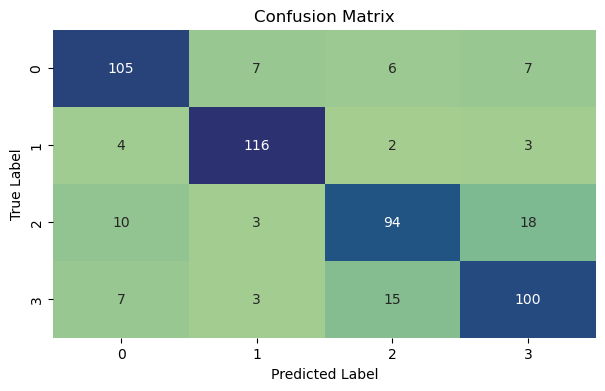

In [53]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_true, y_predicted_list)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Classification Score Table

In [54]:
# Generate classification report

class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Replace with your class names
report = classification_report(y_test_true, y_predicted_list, target_names=class_names, output_dict=True)

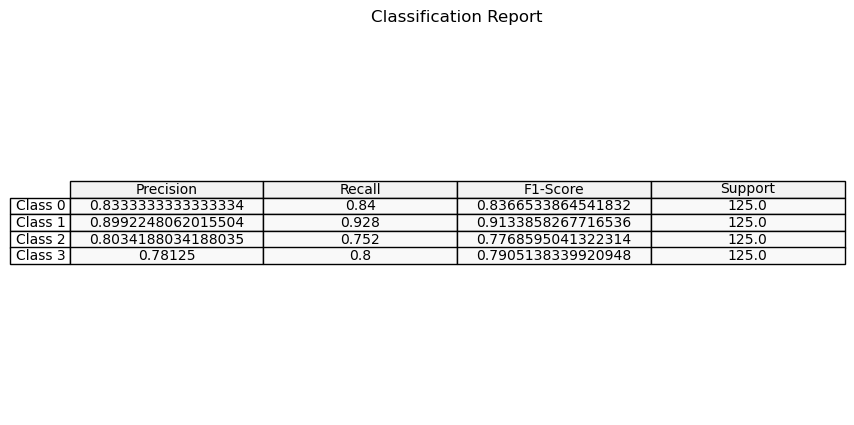

In [55]:
# Convert classification report to a numpy array
report_data = []
for class_name in class_names:
    report_data.append([
        report[class_name]['precision'],
        report[class_name]['recall'],
        report[class_name]['f1-score'],
        report[class_name]['support']
    ])

# Plot classification report as a table
plt.figure(figsize=(10, 5))
plt.table(cellText=report_data, colLabels=['Precision', 'Recall', 'F1-Score', 'Support'], rowLabels=class_names, loc='center', cellLoc='center', colColours=['#f2f2f2']*4, cellColours=[['#f9f9f9']*4]*len(class_names))
plt.axis('off')  # Turn off axis
plt.title('Classification Report')
plt.show()

#### Write Predictions to test.csv

In [56]:
textClassifierModifiedTestSet = test_set.copy()
textClassifierModifiedTestSet.head()

,index,text,label
0,0,detainees seen minimal threat washington alleg...,0
1,1,japans army works plan cope north korean terro...,0
2,2,un council arrives nairobi un security council...,0
3,3,apec ministers urge new effort trade talks pac...,0
4,4,least five dead russia mine blast reuters reut...,0


In [57]:
textClassifierModifiedTestSet['preds'] = y_predicted_list

In [58]:
test_set.head(10)

,index,text,label
0,0,detainees seen minimal threat washington alleg...,0
1,1,japans army works plan cope north korean terro...,0
2,2,un council arrives nairobi un security council...,0
3,3,apec ministers urge new effort trade talks pac...,0
4,4,least five dead russia mine blast reuters reut...,0
5,5,australia establish NUM lead third india test ...,0
6,6,indonesia businesses hopeful election sufferin...,0
7,7,georgian president calls international confere...,0
8,8,gangs prowl stormwracked haiti ap ap victims l...,0
9,9,india never become international liability man...,0


In [59]:
textClassifierModifiedTestSet.to_csv('w2v_test.csv', index=False)

In [60]:
# Test if it has been written into the file or not

test_df = pd.read_csv('w2v_test.csv')
test_df.head()

,index,text,label,preds
0,0,detainees seen minimal threat washington alleg...,0,0
1,1,japans army works plan cope north korean terro...,0,0
2,2,un council arrives nairobi un security council...,0,0
3,3,apec ministers urge new effort trade talks pac...,0,0
4,4,least five dead russia mine blast reuters reut...,0,0


### Vanilla RNN Implementation

##### Initialising Embedding Layer From the Word2Vec Embeddings

Ref: https://stackoverflow.com/questions/49710537/pytorch-gensim-how-do-i-load-pre-trained-word-embeddings

In [61]:
vocabulary = word2vec_model.wv.index_to_key
word_embeddings = np.array([word2vec_model.wv[word] for word in vocabulary])

# This is the word embeddings we got from training the word2vec model on our dataset.
# The nn.Embedding layer needs to be initialized with this embeddings.

In [62]:
print(f'Size of the vocabulary we have: {len(vocabulary)}\nAnd Shape of the word embeddings is: {word_embeddings.shape}\
        \nSize of the each word vector is: {word_embeddings.shape[1]}'
     )

Size of the vocabulary we have: 13628
And Shape of the word embeddings is: (13628, 100)        
Size of the each word vector is: 100


In [63]:
len(tokenized_sentences)

2500

###### Separating Train and Test Set

In [64]:
X_train_val = tokenized_sentences[:2000]
print(f'X_train_val is of length: {len(X_train_val)}')

X_train_val is of length: 2000


In [65]:
y_train_val = list(y_train_raw) 
y_train_val = torch.tensor(y_train_val)
print(f'y_train_val is of length: {len(y_train_val)}')

y_train_val is of length: 2000


In [66]:
X_test = tokenized_sentences[2000:]
y_test = y_test_raw

print(f'X_test is of length: {len(X_test)}\ny_test is of length: {len(y_test)}')

X_test is of length: 500
y_test is of length: 500


In [67]:
# Split data into train and test sets

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)


In [68]:
print(f'Lengh of X_train is {len(X_train)}')
print(f'Lengh of y_train is {len(y_train)} \n')
print(f'Lengh of X_train is {len(X_val)}')
print(f'Lengh of y_test is {len(y_val)}')

Lengh of X_train is 1800
Lengh of y_train is 1800 

Lengh of X_train is 200
Lengh of y_test is 200


##### Custom Dataset Creation 

In [69]:
class NewsDataset(Dataset):
    
    def __init__(self, data, labels, vocab):
        self.data = data
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        news = self.data[idx]
        tokens = [self.vocab.index(word) for word in news]
        return torch.tensor(tokens), torch.tensor(self.labels[idx])


In [70]:
def pad_sequences(batch):
    
    batch_size = len(batch)
    max_len = max([len(seq) for seq, _ in batch])
        
    padded_seqs = torch.zeros(batch_size, max_len, dtype=torch.long)
    labels = torch.zeros(batch_size, dtype=torch.long)
    
    for i, (seq, label) in enumerate(batch):
        padded_seqs[i, 0:len(seq)] = seq
        labels[i] = label
        
    return padded_seqs, labels

In [71]:
# Creating DataLoader for batch processing 

train_dataset = NewsDataset(X_train, y_train, vocabulary)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = pad_sequences)

In [72]:
val_dataset = NewsDataset(X_val, y_val, vocabulary)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, collate_fn = pad_sequences)

In [73]:
test_dataset = NewsDataset(X_test, y_test, vocabulary)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False, collate_fn = pad_sequences)

#### Define the Architecture

In [74]:
# Define the vanilla RNN model with custom embedding layer

class biRNN(nn.Module):
    
    def __init__(self, word_vector_size, hidden_size, output_size):
        super(biRNN, self).__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze = True)
        self.rnn = nn.RNN(word_vector_size, hidden_size, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.Softmax(dim = 1)

    # There are 2*hidden_units in the linear layee bcz of the bidirectional nature of the RNN

    def forward(self, x):
        
        embedded = self.embedding_layer(x)
        output, _ = self.rnn(embedded)
        
        # Average pooling along the sequence dimension
        avg_pooled = torch.mean(output, dim=1)  # Compute mean across the sequence dimension (dimension 1)
        output = self.fc(avg_pooled)  
        
        softMaxedOutput = self.softmax(output)

        return output

In [75]:
# Total number of tokens we have
vocab_size = len(word2vec_model.wv)

# Size of the embedding vector that will be created by the embedding layer
word_vector_size = 100

# no. of nodes in the RNN Layer
hidden_size = 200

# Number of classes
output_size = 4  

In [76]:
device = 'cuda'

In [77]:
# Instantiate RNN

biRNNModel = biRNN(word_vector_size, hidden_size, output_size).to(device)
biRNNModel

biRNN(
  (embedding_layer): Embedding(13628, 100)
  (rnn): RNN(100, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [78]:
# Define loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer_rnn = optim.Adam(biRNNModel.parameters(), lr = 0.0001)

In [79]:
num_epochs = 20
performance_metrics = []
best_val_accuracy = 0

for epoch in tqdm(range(num_epochs)):
    
    biRNNModel.train()
    train_loss = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        X, y = X.to(device), y.to(device)
        y_pred = biRNNModel(X)
                
        # calculate batch accumulative loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer_rnn.zero_grad()
        
        loss.backward()
        
        optimizer_rnn.step()
        
    with torch.inference_mode():
        
        biRNNModel.eval()
        val_loss, val_accuracy = 0,0
        
        for X_val, y_val in val_loader:
            
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            y_val_pred = biRNNModel(X_val)
            
            loss = loss_fn(y_val_pred, y_val)
            val_loss += loss
            val_accuracy += accuracy_fn(y_val, y_val_pred.argmax(dim=1))
        
        # Calculate avg. loss & accuracy
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        
        print(f"Epoch:{epoch+1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")
        performance_metrics.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            torch.save(biRNNModel.state_dict(), './wt_initialised_BiRnn.pth')
            print('Model State Dict Saved\n')
            best_val_accuracy = val_accuracy

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_1218907/4133067633.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tokens), torch.tensor(self.labels[idx])


Epoch:1 | Train loss: 1.0958 | Val loss: 0.7357 | Val accuracy: 77.8846
Model State Dict Saved

Epoch:2 | Train loss: 0.6586 | Val loss: 0.5951 | Val accuracy: 78.8462
Model State Dict Saved

Epoch:3 | Train loss: 0.5726 | Val loss: 0.5650 | Val accuracy: 80.2885
Model State Dict Saved

Epoch:4 | Train loss: 0.5423 | Val loss: 0.5188 | Val accuracy: 80.7692
Model State Dict Saved

Epoch:5 | Train loss: 0.5169 | Val loss: 0.5341 | Val accuracy: 78.8462
Epoch:6 | Train loss: 0.5150 | Val loss: 0.4936 | Val accuracy: 81.2500
Model State Dict Saved

Epoch:7 | Train loss: 0.5061 | Val loss: 0.5146 | Val accuracy: 78.3654
Epoch:8 | Train loss: 0.5005 | Val loss: 0.5210 | Val accuracy: 81.2500
Epoch:9 | Train loss: 0.4907 | Val loss: 0.5013 | Val accuracy: 84.1346
Model State Dict Saved

Epoch:10 | Train loss: 0.4873 | Val loss: 0.5268 | Val accuracy: 81.2500
Epoch:11 | Train loss: 0.4821 | Val loss: 0.4945 | Val accuracy: 81.7308
Epoch:12 | Train loss: 0.4736 | Val loss: 0.4746 | Val accurac

### Evaluation On Test Set

In [80]:
# Load the latest Best checkpoint saved above.
y_predicted_list_rnn, y_test_true_rnn = [],[]

biRNNModel.load_state_dict(torch.load('./wt_initialised_BiRnn.pth'))

with torch.inference_mode():
    biRNNModel.eval()
    test_loss, test_accuracy = 0,0

    for X_test, y_test in tqdm(test_loader):

        X_test, y_test = X_test.to(device), y_test.to(device)
        
        y_test_pred = biRNNModel(X_test)
        
        y_predicted_list_rnn.append(y_test_pred.argmax(dim = 1))
        y_test_true_rnn.append(y_test)

        loss = loss_fn(y_test_pred, y_test)
        test_loss += loss
        test_accuracy += accuracy_fn(y_test, y_test_pred.argmax(dim=1))

    # Calculate avg. loss & accuracy
    
    test_loss = test_loss/len(test_loader)
    test_accuracy = test_accuracy/len(test_loader)

    print(f"Test loss: {test_loss} | Test accuracy: {test_accuracy}")

  0%|          | 0/32 [00:00<?, ?it/s]

Test loss: 0.5461477041244507 | Test accuracy: 81.0546875


#### Test Accuracy of the Bi-RNN

In [81]:
print(f'Test Accuracy for the Bi-RNN model is: {test_accuracy:.2f} %')

Test Accuracy for the Bi-RNN model is: 81.05 %


In [82]:
# Convert the list of tensors to a single list of elements

y_predicted_list_rnn = [item for tensor in y_predicted_list_rnn for item in tensor.tolist()]
y_test_true_rnn = [item for tensor in y_test_true_rnn for item in tensor.tolist()]

#### F1-Score

In [83]:
f1 = f1_score(np.array(y_test_true_rnn), np.array(y_predicted_list_rnn), average='weighted')
print(f'F1 Score for the model is: {f1:.4f}')

F1 Score for the model is: 0.8126


#### Confusion Matrix

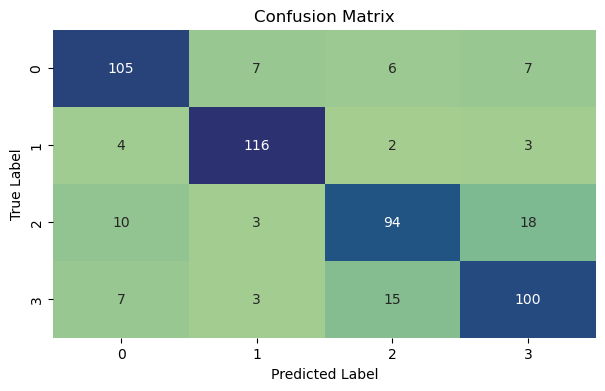

In [84]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_true, y_predicted_list)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Write Prediction to CSV

In [85]:
biRNNModifiedTestSet = test_set.copy()
biRNNModifiedTestSet.head()

,index,text,label
0,0,detainees seen minimal threat washington alleg...,0
1,1,japans army works plan cope north korean terro...,0
2,2,un council arrives nairobi un security council...,0
3,3,apec ministers urge new effort trade talks pac...,0
4,4,least five dead russia mine blast reuters reut...,0


In [86]:
biRNNModifiedTestSet['preds'] = y_predicted_list_rnn

In [87]:
biRNNModifiedTestSet.to_csv('rnn_test.csv', index=False)

In [88]:
# Test if the data has been written to the csv

df = pd.read_csv('rnn_test.csv')
df.head()

,index,text,label,preds
0,0,detainees seen minimal threat washington alleg...,0,0
1,1,japans army works plan cope north korean terro...,0,0
2,2,un council arrives nairobi un security council...,0,0
3,3,apec ministers urge new effort trade talks pac...,0,0
4,4,least five dead russia mine blast reuters reut...,0,0


### LSTM Implementation

Embedding Layer Initialisation, Dataloaders stays the same

In a bidirectional LSTM (BiLSTM), there are two sets of hidden states: one for the forward direction and one for the backward direction. Each set has its own hidden size, which is typically denoted as hidden_size.

When you concatenate the forward and backward hidden states together, you effectively double the size of the hidden state. For example, if hidden_size is 128, then the concatenated hidden state size becomes 128 * 2 = 256. This is because you are combining the hidden states from both directions into a single vector.

In [89]:
class vanillaLSTM(nn.Module):
    
    def __init__(self, word_vector_size, hidden_size, output_nodes):
        super(vanillaLSTM, self).__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze = True)
        self.lstm = nn.LSTM(word_vector_size, hidden_size, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, output_nodes)
        self.softmax = nn.Softmax( dim = 1 )
        
        # There are 2*hidden_units in the linear layee bcz of the bidirectional nature of the LSTM
        
    def forward(self, x):
        
        embedding_output = self.embedding_layer(x)
        output, hidden_state = self.lstm(embedding_output)
        
        # Average pooling along the sequence dimension
        avg_pooled = torch.mean(output, dim=1)  

        linear_output = self.fc(avg_pooled)
        softmaxed_output= self.softmax(linear_output)
        
        return softmaxed_output

In [90]:
# Total number of tokens we have
vocab_size = len(word2vec_model.wv)

# Size of the embedding vector that will be created by the embedding layer
word_vector_size = 100

# no. of nodes in the RNN Layer
hidden_size = 200

# Number of classes
output_size = 4  

# no. of epochs
num_epochs = 20

In [91]:
# Instantiate LSTM

vanillaLSTM = vanillaLSTM(word_vector_size, hidden_size, output_size).to(device)
vanillaLSTM

vanillaLSTM(
  (embedding_layer): Embedding(13628, 100)
  (lstm): LSTM(100, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [92]:
# Define optimizer for the LSTM

optimizer_lstm = optim.AdamW(vanillaLSTM.parameters(), lr=0.00005)

In [93]:
performance_metrics = []
best_val_accuracy = 0

for epoch in tqdm(range(num_epochs)):
    
    vanillaLSTM.train()
    train_loss = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        X, y = X.to(device), y.to(device)
        y_pred = vanillaLSTM(X)
                
        # calculate batch accumulative loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer_lstm.zero_grad()
        
        loss.backward()
        
        optimizer_lstm.step()
        
    with torch.inference_mode():
        
        vanillaLSTM.eval()
        val_loss, val_accuracy = 0,0
        
        for X_val, y_val in val_loader:
            
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            y_val_pred = vanillaLSTM(X_val)
            
            loss = loss_fn(y_val_pred, y_val)
            val_loss += loss
            val_accuracy += accuracy_fn(y_val, y_val_pred.argmax(dim=1))
        
        # Calculate avg. loss & accuracy
        
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        val_accuracy = val_accuracy/len(val_loader)
        
        print(f"Epoch:{epoch+1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")
        performance_metrics.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            torch.save(vanillaLSTM.state_dict(), './wt_initialised_lstm.pth')
            print('Model Checkpoint Saved\n')
            best_val_accuracy = val_accuracy

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_1218907/4133067633.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tokens), torch.tensor(self.labels[idx])


Epoch:1 | Train loss: 1.3726 | Val loss: 1.3511 | Val accuracy: 62.5000
Model Checkpoint Saved

Epoch:2 | Train loss: 1.2732 | Val loss: 1.1570 | Val accuracy: 61.5385
Epoch:3 | Train loss: 1.0608 | Val loss: 1.0509 | Val accuracy: 75.9615
Model Checkpoint Saved

Epoch:4 | Train loss: 1.0038 | Val loss: 1.0102 | Val accuracy: 77.4038
Model Checkpoint Saved

Epoch:5 | Train loss: 0.9730 | Val loss: 0.9743 | Val accuracy: 79.8077
Model Checkpoint Saved

Epoch:6 | Train loss: 0.9554 | Val loss: 0.9735 | Val accuracy: 78.3654
Epoch:7 | Train loss: 0.9414 | Val loss: 0.9546 | Val accuracy: 80.2885
Model Checkpoint Saved

Epoch:8 | Train loss: 0.9323 | Val loss: 0.9425 | Val accuracy: 81.7308
Model Checkpoint Saved

Epoch:9 | Train loss: 0.9272 | Val loss: 0.9355 | Val accuracy: 82.6923
Model Checkpoint Saved

Epoch:10 | Train loss: 0.9198 | Val loss: 0.9309 | Val accuracy: 82.6923
Epoch:11 | Train loss: 0.9131 | Val loss: 0.9254 | Val accuracy: 83.1731
Model Checkpoint Saved

Epoch:12 | Tra

### Evaluation on Test Set

In [94]:
# Load the latest Best checkpoint saved above.

y_predicted_list_lstm, y_test_true_lstm = [],[]

vanillaLSTM.load_state_dict(torch.load('./wt_initialised_lstm.pth'))

with torch.inference_mode():
    vanillaLSTM.eval()
    test_loss, test_accuracy = 0,0

    for X_test, y_test in tqdm(test_loader):

        X_test, y_test = X_test.to(device), y_test.to(device)
        
        y_test_pred = vanillaLSTM(X_test)
        
        y_predicted_list_lstm.append(y_test_pred.argmax(dim = 1))
        y_test_true_lstm.append(y_test)

        loss = loss_fn(y_test_pred, y_test)
        test_loss += loss
        test_accuracy += accuracy_fn(y_test, y_test_pred.argmax(dim=1))

    # Calculate avg. loss & accuracy
    
    test_loss = test_loss/len(test_loader)
    test_accuracy = test_accuracy/len(test_loader)

    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.4f}")

  0%|          | 0/32 [00:00<?, ?it/s]

Test loss: 0.9382 | Test accuracy: 80.8594


#### Test Accuracy of the Bi-LSTM

In [95]:
print(f'Test Accuracy for the Bi-LSTM model is: {test_accuracy:.2f} %')

Test Accuracy for the Bi-LSTM model is: 80.86 %


In [96]:
# Convert the list of tensors to a single list of elements

y_predicted_list_lstm = [item for tensor in y_predicted_list_lstm for item in tensor.tolist()]
y_test_true_lstm = [item for tensor in y_test_true_lstm for item in tensor.tolist()]

#### F-1 Score

In [97]:
f1 = f1_score(np.array(y_test_true_lstm), np.array(y_predicted_list_lstm), average='weighted')
print(f'F1 Score for the model is: {f1:.4f}')

F1 Score for the model is: 0.8090


#### Confusion Matrix

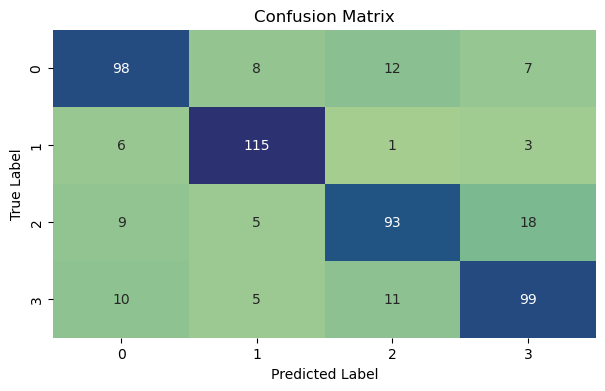

In [98]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_true_lstm, y_predicted_list_lstm)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Write Predictions to CSV

In [99]:
biLSTMModifiedTestSet = test_set.copy()
biLSTMModifiedTestSet.head()

,index,text,label
0,0,detainees seen minimal threat washington alleg...,0
1,1,japans army works plan cope north korean terro...,0
2,2,un council arrives nairobi un security council...,0
3,3,apec ministers urge new effort trade talks pac...,0
4,4,least five dead russia mine blast reuters reut...,0


In [100]:
biLSTMModifiedTestSet['preds'] = y_predicted_list_lstm

In [101]:
biLSTMModifiedTestSet.to_csv('lstm_test.csv', index=False)

In [102]:
# Test if the data has been written to the csv

df = pd.read_csv('lstm_test.csv')
df.head()

,index,text,label,preds
0,0,detainees seen minimal threat washington alleg...,0,0
1,1,japans army works plan cope north korean terro...,0,0
2,2,un council arrives nairobi un security council...,0,0
3,3,apec ministers urge new effort trade talks pac...,0,0
4,4,least five dead russia mine blast reuters reut...,0,0
